# Algorithms in Machine Learning
## Student: Javier CUADRADO ANÍBARRO

# Introduction

The aim of this notebook is to present the possible advantages of multidimensional genetic programming for multiclass classification, comparing it to other most common classification methods such as neural networks. The source article for this notebook can be found in the following link:

https://www.sciencedirect.com/science/article/pii/S2210650217309136

# Data generation

We are going to begin by creating the data with which we will work. Our data will consist of a set of $\mathbb{R}^4$ points obtained the following way:

$$\left\{\begin{array}{ll} x_1 \cdot x_3 - x_2 \cdot x_4 & = A \\ x_1 \cdot x_4 - x_2 \cdot x_3 & = B\end{array}\right.$$

Of course, the generation of the poins will be noisy, so the relationship between the values will not exactly add A or B, but something in between.

In [1]:
import numpy as np

In [2]:
def generate_point(A,B,attenuation=10):
    x1 = np.random.uniform(-5,5)
    x2 = np.random.uniform(-5,5)
    x3 = (x1*A+x2*B)/(x1**2+x2**2)
    x4 = (x1*B-x2*A)/(x1**2+x2**2)
    x = [x1, x2, x3, x4] + np.random.randn(1,4)/attenuation
    x = np.float32(x)
    return x[0,:]

In [3]:
def decode(x):
    A = x[0]*x[2]-x[1]*x[3]
    B = x[0]*x[3]+x[1]*x[2]
    return [A, B]

In [4]:
x_test = generate_point(5,5)
print(x_test)

[4.4814806  0.7419539  1.2988604  0.86106163]


In [5]:
decode(x_test)

[5.18195, 4.8225255]

In [6]:
from sklearn.utils import shuffle

def generate_data(points_per_cat):
    X = np.zeros((4*points_per_cat,4))
    y = np.zeros((4*points_per_cat,1))

    for i in range(points_per_cat):
        X[i,:] = generate_point(0,0)
        y[i,:] = 0
    
    for i in range(points_per_cat, 2*points_per_cat):
        X[i,:] = generate_point(0,5)
        y[i,:] = 1

    for i in range(2*points_per_cat, 3*points_per_cat):    
        X[i,:] = generate_point(5,0)
        y[i,:] = 2

    for i in range(3*points_per_cat, 4*points_per_cat):
        X[i,:] = generate_point(5,5)
        y[i,:] = 3
    
    X, y = shuffle(X, y)
    
    return X, y

X, y = generate_data(100)
Xval, yval = generate_data(50)
Xtest, ytest = generate_data(25)

## Data to tensor

In order to work with pytorch, we convert our numpy arrays into pytorch tensors.

In [7]:
import torch
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
def data_to_tensor(X,y):
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).long()
    
    return X_tensor, y_tensor

X_tensor, y_tensor = data_to_tensor(X,y)
Xval_tensor, yval_tensor = data_to_tensor(Xval, yval)
Xtest_tensor, ytest_tensor = data_to_tensor(Xtest, ytest)


# Neural network on raw data

## Architecture 

We proceed now to the classification of the generated data with our neural network. We have defined a 3-hidden-layer architecture, each of the hidden layers with 10 neurons and a ReLU activation

In [9]:
from torch import nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1, 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x
    
net = SimpleNet()

## Training

For the training of the NN, we will use a batch size of 20 both for the training and the validation sets. Furthermore, a maximum of 50 epochs will be allowed, with an ealy stopping patience of 5 epochs.

In [10]:
class EarlyStopping:
    
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: %d / %d' % (self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [11]:
def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            inputs = Xval_tensor[data, :]
            labels = yval_tensor[data, :].resize(20)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train(net, earlystopping=True):
#     optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    optimizer = torch.optim.Adam(net.parameters())
    train_history = []
    valid_history = []
    estop = EarlyStopping(patience=5)
    for epoch in range(50):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = X_tensor[data, :]
            labels = y_tensor[data, :].resize(20)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
        estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history

In [12]:
def plot_train_val(train, valid):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 00: train loss 27.65754, validation loss 13.88265
Epoch 01: train loss 27.46878, validation loss 13.80498
Epoch 02: train loss 27.22289, validation loss 13.71244
Epoch 03: train loss 26.94583, validation loss 13.61395
Epoch 04: train loss 26.66012, validation loss 13.51189
Epoch 05: train loss 26.35101, validation loss 13.38679
Epoch 06: train loss 25.99729, validation loss 13.24989
Epoch 07: train loss 25.61580, validation loss 13.09592
Epoch 08: train loss 25.22340, validation loss 12.95465
Epoch 09: train loss 24.84440, validation loss 12.80684
Epoch 10: train loss 24.44014, validation loss 12.65766
Epoch 11: train loss 24.04533, validation loss 12.52474
Epoch 12: train loss 23.69120, validation loss 12.40845
Epoch 13: train loss 23.28639, validation loss 12.25419
Epoch 14: train loss 22.88201, validation loss 12.10183
Epoch 15: train loss 22.44733, validation loss 11.94624
Epoch 16: train loss 22.05369, validation loss 11.78633
Epoch 17: train loss 21.64304, validation loss 1

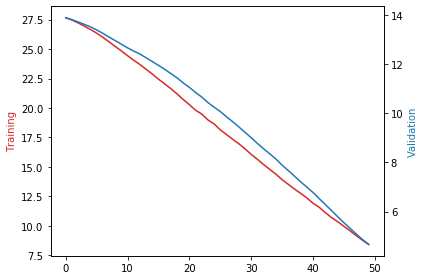

In [13]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet()
train_history, valid_history = train(net)
plot_train_val(train_history, valid_history)

Confusion matrix


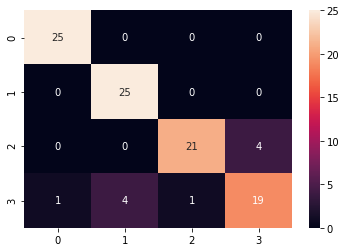

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
outputs = net(Xtest_tensor)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)

We can see that our NN is reasonably accurate. The discrepancies between the true data and the predicted values come from the noise introduced in data generation (lower noise yields higher accuracies), as well as the low number of epochs. However, a longer training may lead to overfitting, since the neural network may simply end up by learning the noise as a value, a detrimental feature for our intended goal.

# Neural network on transformed data

We proceed now to perform the same analysis on the decoded dataset

In [15]:
X_decoded = torch.zeros([400, 2], dtype=torch.float)
for i in range(400):
    X_decoded[i,:] = torch.FloatTensor(decode(X_tensor[i,:]))
    
Xval_decoded = torch.zeros([200, 2], dtype=torch.float)
for i in range(200):
    Xval_decoded[i,:] = torch.FloatTensor(decode(Xval_tensor[i,:]))
    
Xtest_decoded = torch.zeros([100, 2], dtype=torch.float)
for i in range(100):
    Xtest_decoded[i,:] = torch.FloatTensor(decode(Xtest_tensor[i,:]))

In [16]:
class SimpleNet_2in(nn.Module):
    def __init__(self):
        super(SimpleNet_2in, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1, 2)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [17]:
def validation(net):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            inputs = Xval_decoded[data, :]
            labels = yval_tensor[data, :].resize(20)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

In [18]:
def train(net, earlystopping=True):
#     optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    optimizer = torch.optim.Adam(net.parameters())
    train_history = []
    valid_history = []
    estop = EarlyStopping(patience=5)
    for epoch in range(50):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = X_decoded[data, :]
            labels = y_tensor[data, :].resize(20)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
        estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 00: train loss 28.27576, validation loss 14.00728
Epoch 01: train loss 27.93608, validation loss 13.93753
Epoch 02: train loss 27.76765, validation loss 13.75890
Epoch 03: train loss 27.10311, validation loss 13.33702
Epoch 04: train loss 26.25315, validation loss 12.87733
Epoch 05: train loss 25.28855, validation loss 12.37173
Epoch 06: train loss 24.14850, validation loss 11.70723
Epoch 07: train loss 22.82898, validation loss 11.07001
Epoch 08: train loss 21.56621, validation loss 10.42090
Epoch 09: train loss 19.63205, validation loss 9.05104
Epoch 10: train loss 16.72589, validation loss 7.56519
Epoch 11: train loss 13.90128, validation loss 6.29147
Epoch 12: train loss 11.61715, validation loss 5.28577
Epoch 13: train loss 9.82565, validation loss 4.47552
Epoch 14: train loss 8.29172, validation loss 3.78131
Epoch 15: train loss 6.97174, validation loss 3.13467
Epoch 16: train loss 5.77250, validation loss 2.59723
Epoch 17: train loss 4.77471, validation loss 2.14823
Epoch 

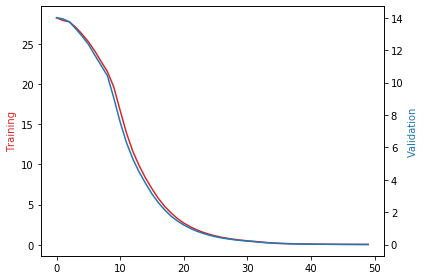

In [19]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet_2in()
train_history, valid_history = train(net)
plot_train_val(train_history, valid_history)

Confusion matrix


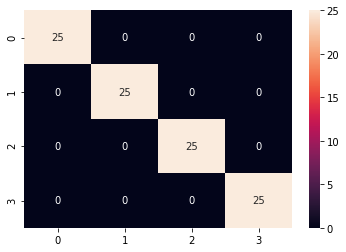

In [20]:
y_pred = []
outputs = net(Xtest_decoded)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)

As expected, the decoded dataset perfoms better than the raw one, being able to mitigate the noise influence on the classification. However, we have cheated on this analysis, since we knew the decoding algorithm prior to making the data classification. In real life, the data decoding may not be known, so we should be able to find a way to learn it.

# Genetic Programming

In [21]:
import random

x = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
data_len = x.shape[1]

def program_generator(data_len):
    program_len = random.randint(2,20)
    
    program = []
    
    
    values = [i for i in range(data_len)]
    
    program.append(random.choice(values))
    program.append(random.choice(values))

    values.append('+')
    values.append('-')
    values.append('*')
    values.append('/')
    
    for i in range(2,program_len):
        program.append(random.choice(values))
    
    return program

program = program_generator(data_len)
print(program)   



[1, 1, 4, '/', 1, 3, '+', 0, '*', '*', 3, '*']


program = $[0, 2, '*', 1, 3, '*', '-', 0, 3, '*', 1, 2, '*', '+']$

In [22]:
def program_reader(program, x):
    output = []
    for ele in program:
        if type(ele) == int:
            output.append(x[:,ele])
        else:
            try:
                b = output.pop()
                a = output.pop()
                if ele == '+':
                    output.append(a+b)
                elif ele == '-':
                    output.append(a-b)
                elif ele == '*':
                    output.append(a*b)
                elif ele == '/' and b != 0:
                    output.append(a/b)
                else:
                    raise
            except:
                output = 'Error'
                break
           
    if output == 'Error':
        outmat = 'Error'
    else:
        newdim = len(output)
    
        outmat = np.zeros((x.shape[0],newdim))
        for ele in range(newdim):
            outmat[:,ele] = output[ele]
        
    return outmat 

In [23]:
population_size = 50
population = []
errors = []

x = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])

for i in range(population_size):
    population.append(program_generator(data_len))

In [24]:
output = []
for i in range(population_size):
    output.append(program_reader(population[i], x))
    if type(output[-1]) == str:
        errors.append(i)

errors.reverse()        

for err in errors:
    output.pop(err)
    population.pop(err)

In [25]:
population

[[0, 0, '+'],
 [3, 4],
 [0, 3, 0, 3, '+', 2, '+', 0, 2],
 [4, 2, 1, '*', '*', 3, 1, 1],
 [4, 1],
 [1, 3, '+'],
 [0, 4, 1, '-'],
 [3, 3, 2, '*', 4, 4, 2, '+', 1],
 [1, 4, 1, 4, 2, 1, '+', 1, '+', '+'],
 [4, 2, 1, '+', 1, 1, '*', 2, '+', '*', 4, '-', 0, '*', 2, 3, '-', '*', 4],
 [3, 4, 0, '+', 1],
 [4, 4, 1, 0, '+'],
 [0, 0, 4, '+', 4, 2, '-', '-', 1, 1, 0, 1, 4, 0, 2],
 [3, 0, 3, 0, '-'],
 [2, 1, 0, 4, 2, '+', 2, 2, '-'],
 [1, 2, 3, 4, 0, 2, '*', 4],
 [2, 4, 3, '-', 2, 3, 4, '+', '+', '*', 3, 4]]

In [26]:
from sklearn.neighbors import NearestCentroid
from tqdm import tqdm

max_generations = 5000
population_size = 500
population = []
y = y.reshape((400,))

for gen in tqdm(range(max_generations)):
    
    while len(population) > 0.5*population_size:
        population.pop()
    
    for ind in range(len(population), population_size):
        population.append(program_generator(X.shape[1]))
        
    output = []
    errors = []
    for i in range(population_size):
        output.append(program_reader(population[i], X))
        if type(output[-1]) == str:
            errors.append(i)

    errors.reverse()        

    for err in errors:
        output.pop(err)
        population.pop(err)
        
    score = []
    for i in range(len(output)):
        clf = NearestCentroid()
        clf.fit(output[i], y)
#         y_pred = clf.predict(output[i])
        score.append(clf.score(output[i],y))
    
    keys = sorted(range(len(score)), key=lambda k: score[k])
    keys.reverse()
    
    population_ordered = []
    for k in keys:
        population_ordered.append(population[k])
    population = population_ordered
    
print(population[0])

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [15:23<00:00,  5.41it/s]

[3, 0, '*', 3, 1, '*', 2, '-', 1, 1, 2, 2, '-', 1, 1, 2, '*']


Confusion matrix


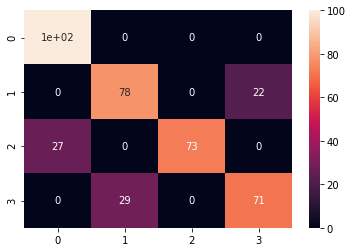

In [27]:
program = population[0]
X_trans = program_reader(program, X)
clf = NearestCentroid()
clf.fit(X_trans, y)
y_pred = clf.predict(X_trans)
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(cf_matrix, annot=True)

Confusion matrix


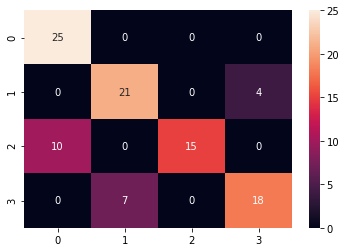

In [28]:
Xtest_trans = program_reader(program, Xtest)
ytest = ytest.reshape((100,))
ytest_pred = clf.predict(Xtest_trans)
print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, ytest_pred)
sns.heatmap(cf_matrix, annot=True)

In [29]:
# from sklearn.neural_network import MLPClassifier

# y_onehot_array = y_onehot.numpy()
# y_onehot_array

# myNN = MLPClassifier(hidden_layer_sizes=(8,16,8))
# myNN.fit(X, y_onehot_array)

In [30]:
# trainloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# train_loss = 0.0
# for i, data in enumerate(trainloader, 0):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs = X_tensor[data, :]
#     print(inputs)
#     labels = y_tensor[data, :].resize(20)
#     print(labels)
#     # zero the parameter gradients
#     optimizer.zero_grad()
#     # forward + backward + optimize
#     outputs = net(inputs)
#     print(outputs)
#     loss = criterion(outputs, labels)
#     print(loss)
#     print(type(loss))
#     loss.backward()
#     optimizer.step()
#     train_loss += loss.item()